<a href="https://colab.research.google.com/github/Shi-raishi/Research/blob/main/pattern3_fnutr1_ratio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ③②の変数をE_CR～E_SSまでの和で除した１７食品群別エネルギー摂取比率<br>
## 補正なし<br>
穀類E_CR			いも類E_PT					砂糖・甘味料類E_SG		豆類E_PL
緑黄色野菜E_GV	その他の野菜*E_OV		果実類E_FR						魚介類E_FS
肉類E_MT			卵類E_EG					乳類E_MK						油脂類E_OL
菓子類E_SW		嗜好飲料類E_BR			調味料・香辛料類E_SS


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Google Colabにlingamのライブラリをインストールする
!pip install lingam

In [ ]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot
from lingam.utils import print_causal_directions, print_dagc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

['1.26.2', '1.5.3', '0.20.1', '1.8.2']


##  関数を定義

In [ ]:
# 前処理用（結合、重複削除、NA削除）
def preprocess(df1, df2):
  # df1, df2の重複を確認
  print(f"ID1に重複のある行数\tdf1:{df1['ID1'].duplicated(keep=False).sum()}\tdf2:{df2['ID1'].duplicated(keep=False).sum()}")

  # df2からID1の重複を除去
  df2_cleaned = df2.drop_duplicates(subset='ID1', keep=False)

  # 左結合
  merged_data = pd.merge(df1, df2_cleaned, on='ID1', how='left')

  # 結合後のデータフレームのID1の重複を削除
  merged_data = merged_data.drop_duplicates(subset='ID1',keep=False)# 重複の確認
  print(f"結合後のデータ数:{len(merged_data)}")

  ## エネルギー補正係数とBMIを作成
  # merged_dataのコピーを作成（SettingWithCopyWarningというエラーが出るため）
  merged_data_copy = merged_data.copy()

  # 新しい列を追加(ECF:Energy correction facto(エネルギー補正係数))
  merged_data_copy['BMI'] = merged_data_copy['BW'] / ((merged_data_copy['BH'] / 100) ** 2)
  merged_data_copy['total_intake'] = merged_data_copy.loc[:, 'E_CR':'E_SS'].sum(axis=1)

  # 変数を選択
  selected_columns = merged_data_copy.loc[:, 'E_CR':'E_SS'].copy()
  selected_columns['total_intake'] = merged_data_copy['total_intake']
  selected_columns['BMI'] = merged_data_copy['BMI']
  selected_columns['AGE'] = merged_data_copy['AGE']
  selected_columns['SEX'] = merged_data_copy['SEX']

  # NA処理
  print(f"NAを含むデータ数:{selected_columns[selected_columns.isna().any(axis=1)].shape[0]}")
  selected_columns_cleaned = selected_columns.dropna()
  selected_columns_cleaned.describe()
  display(selected_columns_cleaned.describe())

  print(f"処理後のデータ数:{len(selected_columns_cleaned)}")

  return selected_columns_cleaned

In [ ]:
# 変数同士の相関を確認
def corrMatrix(df):
  # 相関行列の作成
  corr_matrix = df.corr()

  # 高い相関を持つ変数ペアの抽出
  threshold = 0.5  # 閾値を設定
  high_corr_var = [(column, index, corr_matrix[column][index]) for column in corr_matrix.columns for index in corr_matrix.columns if (corr_matrix[column][index] > threshold) & (column != index)]
  for var_pair in high_corr_var:
      print(var_pair)

In [ ]:
# 特定の変数と他の変数との相関を確認
def targetCorrMatrix(df):
  df = 'VEG3'
  correlations = df.corrwith(df[df])
  correlations.sort_values(ascending=False)

In [ ]:
# ヒートマップで相関関係の可視化
def heatMap(df):
  plt.figure(figsize=(15, 15))
  sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
  plt.show()

In [ ]:
# 個々の変数の分布を確認
def distribution(df):
  for column in df.columns:
      plt.figure()
      sns.histplot(df[column], kde=True)
      plt.title(column)
      plt.show()

In [ ]:
# 変数の0データを確認
def countZeroData(df):
  # 各変数における0の数をカウントし、少ない順にソート
  zero_counts_sorted = (df == 0).sum().sort_values()
  # 各変数における0データ数の表示
  print(zero_counts_sorted)

In [ ]:
# 0データの数をグラフで確認
def countAvairableVariable(df):
  # 0が含まれる数をカウント
  zero_counts = (df == 0).sum().sort_values()

  # グラフのサイズを設定
  plt.figure(figsize=(12, 9))

  # 棒グラフの作成
  sns.barplot(x=len(df)-zero_counts.values, y=zero_counts.index)

  # グラフのタイトルとラベルを設定
  plt.title('Number of non-zero data in each variable')
  plt.xlabel('number of non-zero data')
  plt.ylabel('variable name')

  # グラフの表示
  plt.show()

In [ ]:
def boxplot(df):
  # dfのすべての列に対して箱ひげ図を描画
  plt.figure(figsize=(10, 6))
  sns.boxplot(data=df)
  plt.title("Boxplot of df")
  plt.show()

In [ ]:
# 与えられたデータフレームの変数を見る
def checksVariables(df):
  # non-zeroのデータ数をグラフで確認
  countAvairableVariable(df)
  # 相関行列を確認
  corrMatrix(df)
  # ヒートマップ確認
  heatMap(df)
  # # 各変数の分布を確認
  # distribution(df)
  # 箱ひげ図を描画
  # boxplot(df)

In [ ]:
# 解析に使用するデータフレームを返す
def select_variables(df,columns):
    # 解析に使用する変数のデータフレームを作成
    df = df[columns]

    # 基本統計量の確認
    # print(f"データ数:{len(df)}")
    # display(df.describe())

    # # 各列について、上:0.05%,下:0.05%のデータを外れ値として除去
    # for column in df.columns:
    #     lower_limit = df[column].quantile(0.005)
    #     upper_limit = df[column].quantile(0.995)
    #     df = df[(df[column] > lower_limit) & (df[column] < upper_limit)]

    # # 修正されたデータフレームを確認
    # print(f"上:0.05%,下:0.05%を除去後のデータ数:{len(df)}")
    # display(df.describe())

    return df

In [ ]:
# 3σ法による外れ値の除去(正規分布)
def remove_outliers_3sigma(df, columns_to_process=None):
    if columns_to_process is None:
        columns_to_process = df.columns
    for column in columns_to_process:
        mean = df[column].mean()
        std = df[column].std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        # print(f"{column}:{len(df)}")
    return df

# IQRによる外れ値の除去
def remove_outliers_iqr(df, columns_to_process=None):
    if columns_to_process is None:
        columns_to_process = df.columns
    for column in columns_to_process:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        # print(f"{column}:{len(df)}")
    return df

# # 使い方
# columns_to_process = ['A', 'B']
# df_cleaned_3sigma = remove_outliers_3sigma(df, columns_to_process)
# df_cleaned_iqr = remove_outliers_iqr(df, columns_to_process)

## データ準備

In [ ]:
%cd /content/drive/MyDrive/'Colab Notebooks'
%ls CSV

/content/drive/MyDrive/Colab Notebooks
'BDHQ フォーマット LongDataSet (f_nutr1).csv'
'BDHQ フォーマット LongDataSet (nutr).csv'
'BDHQ フォーマット LongDataSet (signal).csv'
'BDHQ 児童生徒用フォーマット LongDataSet (food2).csv'
'BDHQ 成人用フォーマット LongDataSet (food).csv'
 Shift-JISに変換したもの/


In [ ]:
# CSVの読み込み
data_nutr = pd.read_csv('./CSV/BDHQ フォーマット LongDataSet (nutr).csv')
data_fnutrRatio = pd.read_csv('./CSV/BDHQ フォーマット LongDataSet (f_nutr1).csv')

In [ ]:
print(len(data_fnutrRatio),len(data_nutr))

3347 3329


In [ ]:
# 前処理（結合、重複削除、NA削除）
preprocessed_df = preprocess(data_fnutrRatio,data_nutr)

ID1に重複のある行数	df1:136	df2:116
結合後のデータ数:3211
NAを含むデータ数:10


,E_CR,E_PT,E_SG,E_PL,E_GV,E_OV,E_FR,E_FS,E_MT,E_EG,E_MK,E_OL,E_SW,E_BR,E_SS,total_intake,BMI,AGE,SEX
count,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000
mean,718.689771,50.382931,18.242908,73.346864,32.430612,38.617966,45.658593,146.023833,137.955238,62.794820,143.457512,96.302732,179.534984,120.785759,54.258016,1918.482540,22.312986,47.716963,1.606061
std,366.072636,44.835944,14.886079,54.604369,22.713888,25.652775,46.245637,122.368556,87.658901,40.147662,122.080654,53.598151,162.742131,177.134201,35.974669,687.879368,3.649318,22.889282,0.488698
min,20.981333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,375.354191,12.326516,10.000000,1.000000
25%,496.960071,17.691071,7.813510,30.781927,16.609424,20.620395,12.303194,63.177733,82.964954,35.060232,56.440000,59.042533,62.329747,19.526190,28.992683,1475.197563,19.735976,25.000000,1.000000
50%,666.221077,42.551282,15.070972,61.333836,27.054116,33.100241,32.739018,111.824445,126.005859,56.948571,116.335714,88.554652,137.361087,46.357143,46.529911,1816.541627,21.953125,53.000000,2.000000
75%,851.585288,69.686258,24.130144,105.481068,42.821983,50.205886,63.978970,191.918296,169.401280,90.432496,193.928571,126.689681,246.446972,130.782143,73.711029,2255.144765,24.444444,67.000000,2.000000
max,5202.143086,330.233334,141.620005,432.728702,177.452680,178.625893,431.759097,1192.206400,951.942218,253.210990,1234.340143,588.183023,1672.645467,2011.630053,261.886802,8682.240493,50.781250,96.000000,2.000000


処理後のデータ数:3201


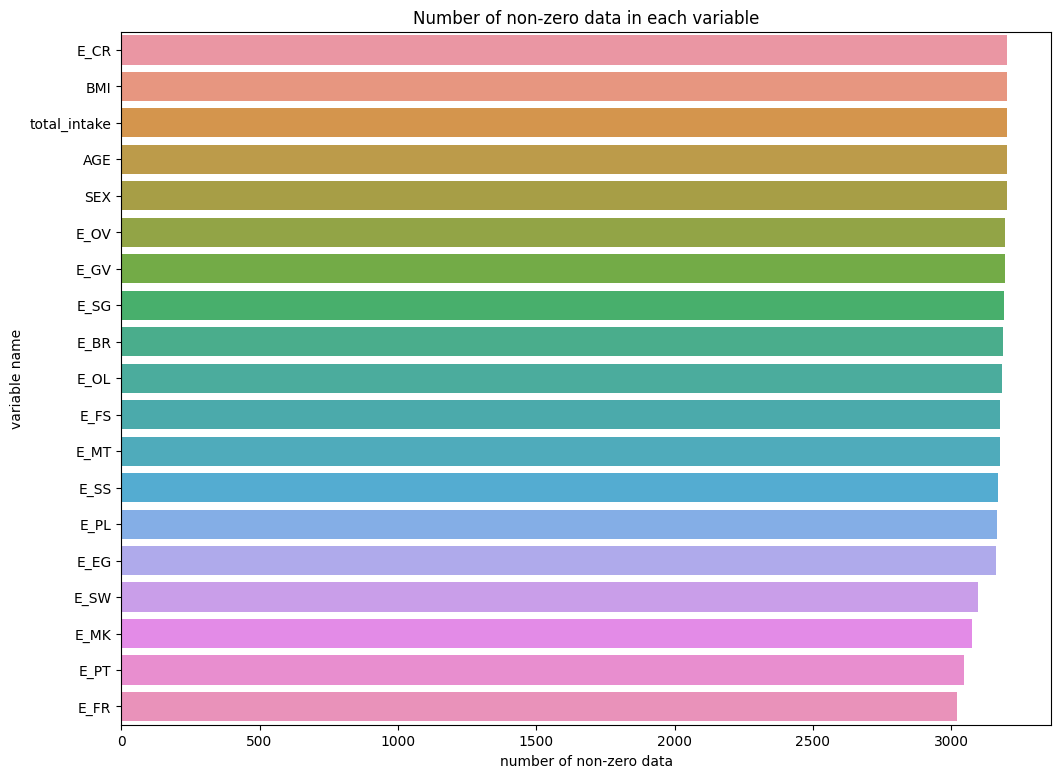

('E_CR', 'total_intake', 0.7269689298722164)
('E_GV', 'E_OV', 0.7040129248500424)
('E_GV', 'E_FR', 0.567757844868274)
('E_OV', 'E_GV', 0.7040129248500424)
('E_FR', 'E_GV', 0.567757844868274)
('E_MT', 'E_OL', 0.5948509316936996)
('E_MT', 'total_intake', 0.5147753251967452)
('E_OL', 'E_MT', 0.5948509316936996)
('E_OL', 'total_intake', 0.5184540702372511)
('total_intake', 'E_CR', 0.7269689298722164)
('total_intake', 'E_MT', 0.5147753251967452)
('total_intake', 'E_OL', 0.5184540702372511)


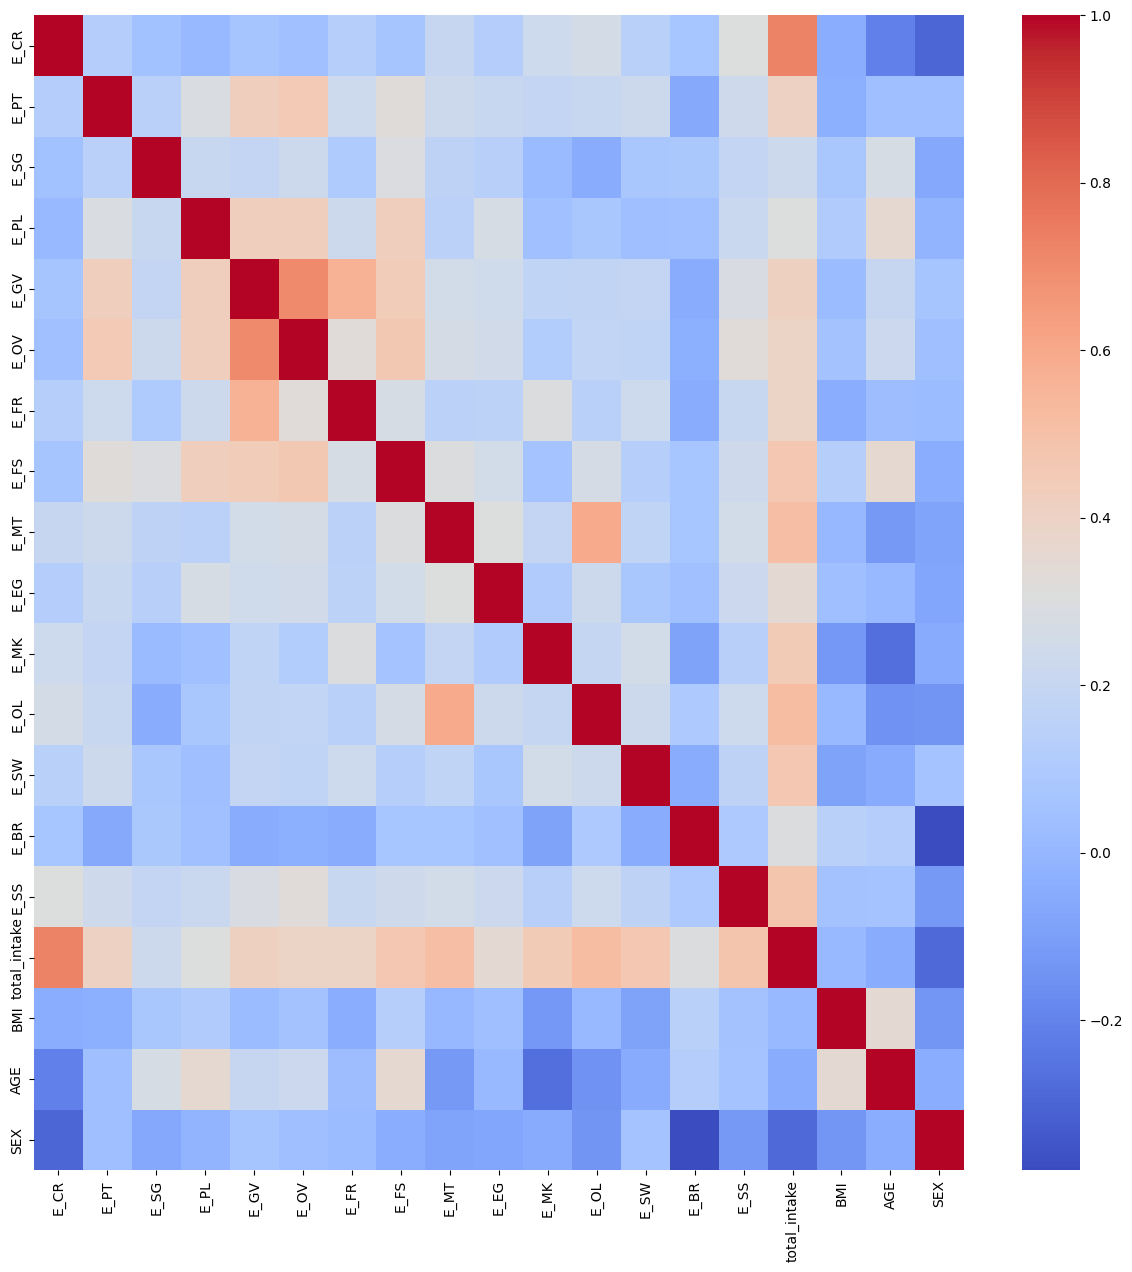

In [ ]:
# 変数の相関を確認
checksVariables(preprocessed_df)

In [ ]:
# 使用する変数を選択
columns_for_lingam = ['E_CR', 'E_PT', 'E_SG', 'E_PL', 'E_GV', 'E_FS', 'E_MT',  'BMI','SEX','AGE']
variables_df = preprocessed_df[columns_for_lingam]
len(variables_df)

3201

In [ ]:
def ecf_outliers_process(df):

  # (AGE,SEXを除く変数)
  columns_to_process = df.columns.to_list()
  columns_to_process.remove('AGE')

  # 箱ヒゲ
  # boxplot(df[columns_to_process])

  # # 各変数の変動係数
  # coeff_of_variation = df[columns_to_process].std() / df[columns_to_process].mean() * 100
  # print(coeff_of_variation)

  # # IQRによる外れ値の除去
  df_cleaned_iqr = remove_outliers_iqr(df,columns_to_process)

  # データフレームから少なくとも1つの変数に0データを含む行を除去
  # df = df[(df != 0).all(axis=1)]

  return df[columns_to_process]

In [ ]:
# fnutrRatio_data_list <- 全体データ、男性群、女性群
fnutrRatio_data_list = []
fnutrRatio_data_list.append(ecf_outliers_process(variables_df.drop(['SEX'], axis=1)))
fnutrRatio_data_list.append(ecf_outliers_process(variables_df[variables_df['SEX'] == 1].drop('SEX', axis=1)))
fnutrRatio_data_list.append(ecf_outliers_process(variables_df[variables_df['SEX'] == 2].drop('SEX', axis=1)))

In [ ]:
for x in fnutrRatio_data_list:
  display(x.describe())
  print(len(x))

,E_CR,E_PT,E_SG,E_PL,E_GV,E_FS,E_MT,BMI
count,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000
mean,718.689771,50.382931,18.242908,73.346864,32.430612,146.023833,137.955238,22.312986
std,366.072636,44.835944,14.886079,54.604369,22.713888,122.368556,87.658901,3.649318
min,20.981333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.326516
25%,496.960071,17.691071,7.813510,30.781927,16.609424,63.177733,82.964954,19.735976
50%,666.221077,42.551282,15.070972,61.333836,27.054116,111.824445,126.005859,21.953125
75%,851.585288,69.686258,24.130144,105.481068,42.821983,191.918296,169.401280,24.444444
max,5202.143086,330.233334,141.620005,432.728702,177.452680,1192.206400,951.942218,50.781250


3201


,E_CR,E_PT,E_SG,E_PL,E_GV,E_FS,E_MT,BMI
count,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000
mean,853.547379,48.150481,19.466736,74.373363,30.666645,152.905070,146.933771,22.924183
std,431.848735,45.380066,16.829492,56.399727,22.664122,125.513741,90.392083,3.806253
min,69.731719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.473917
25%,591.166881,17.691071,7.661990,30.000110,14.661232,68.953452,89.210378,20.324438
50%,791.096674,44.227679,15.921324,62.454766,25.414410,118.926410,135.228403,22.832879
75%,1005.588322,58.970238,25.294294,109.454936,40.456422,199.243564,181.621688,25.217359
max,5202.143086,330.233334,141.620005,432.728702,166.758571,1006.123284,951.942218,42.134301


1261


,E_CR,E_PT,E_SG,E_PL,E_GV,E_FS,E_MT,BMI
count,1940.000000,1940.000000,1940.000000,1940.000000,1940.000000,1940.000000,1940.000000,1940.000000
mean,631.032326,51.834023,17.447421,72.679639,33.577191,141.551029,132.119191,21.915708
std,283.651018,44.430305,13.418268,53.409179,22.678523,120.101428,85.354031,3.487582
min,20.981333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.326516
25%,450.636370,18.722564,7.912430,32.595014,17.415523,60.784749,80.025367,19.531250
50%,609.961036,42.551282,14.711375,60.261515,28.469705,108.019405,122.550469,21.403092
75%,741.618160,76.592308,23.036613,103.848983,43.894585,184.262408,159.957402,23.739956
max,3300.260404,285.944615,91.670000,374.693979,177.452680,1192.206400,800.615625,50.781250


1940


### LiNGAMの関数定義

In [ ]:
def model_DirectLiNGAM(df,dagname):
  # 標準化
  scaler = StandardScaler()
  Xy = scaler.fit_transform(df)

  # モデル作成
  model = lingam.DirectLiNGAM(random_state=1)
  model.fit(Xy)

  # 因果順序
  print(f"因果の順番\n{model.causal_order_}\n\n_________")

  # 隣接行列
  print("隣接行列\n")
  display(model.adjacency_matrix_)
  print("\n")

  # 因果グラフ
  dot = make_dot(
      model.adjacency_matrix_,
      labels = df.columns.to_list(),
      lower_limit = 0.01)
  display(dot)
  dot.format = 'png'
  dot.render(dagname)

  # 推定した因果モデルにおける、誤差同士の独立性のp値
  p_values = model.get_error_independence_p_values(Xy)
  display(p_values)

  return model

In [ ]:
def model_MultiDirectLiNGAM(df_list):
  # 標準化
  scaler = StandardScaler()
  Xy_list = []
  for df in df_list:
    Xy_list.append(scaler.fit_transform(df))

  # モデル作成
  model = lingam.MultiGroupDirectLiNGAM(random_state=1)
  model.fit(Xy_list)

  for index in range(len(Xy_list)):
    # 因果順序
    print(f"因果順序\n{model.causal_order_}\n\n")

    # 隣接行列
    print(f"隣接行列")
    display(model.adjacency_matrices_[index])
    print("\n")

    # 因果グラフの表示と保存
    dot = make_dot(model.adjacency_matrices_[index],
            labels = df_list[index].columns.to_list(),
            lower_limit = 0.01)
    display(dot)
    dot.format = 'png'
    dagname = f"fnutrRatio_Direct{index}"
    dot.render(dagname)

    # 因果モデルにおける誤差同士の独立性のp値
    p_values = model.get_error_independence_p_values(df_list)
    display(p_values[index])

  # return model

In [ ]:
def model_bootstrap(df, n_sampling):
    scaler = StandardScaler()
    Xy = scaler.fit_transform(df)

    model = lingam.DirectLiNGAM(random_state=1)
    result = model.bootstrap(Xy, n_sampling=n_sampling)
    # sklearn.utils.resampleで重複ありのリサンプリングをしている。リサンプル後のサンプル数は元データと同じ。

    # bootstrappingの各サンプルにおける、因果方向の有無のカウント結果を取得する
    cdc = result.get_causal_direction_counts(n_directions=10, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_causal_directions(cdc, n_sampling, labels=df.columns.to_list())

    # カウント結果を確率として、隣接行列の形式で表示
    prob = result.get_probabilities(min_causal_effect=0.01)
    print(prob)

    # bootstrappingの各サンプルにおける、DAG(Directed Acyclic Graphs)のカウント結果を取得する
    dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_dagc(dagc, n_sampling, labels=df.columns.to_list())

    # Total Causal Effects
    causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

    # Assign to pandas.DataFrame for pretty display
    df_ = pd.DataFrame(causal_effects)
    labels = df.columns.to_list()
    # 'from' 列と 'to' 列のラベルを適用する
    df_['from'] = df_['from'].apply(lambda x: labels[x])
    df_['to'] = df_['to'].apply(lambda x: labels[x])
    return df_

In [ ]:
def model_MultiBootstrap(df_list, n_sampling):
    # 標準化
    scaler = StandardScaler()
    Xy_list = []
    for df in df_list:
      Xy_list.append(scaler.fit_transform(df))

    # モデル作成
    model = lingam.MultiGroupDirectLiNGAM(random_state=1)
    result = model.bootstrap(Xy_list, n_sampling=n_sampling)
    # sklearn.utils.resampleで重複ありのリサンプリングをしている。リサンプル後のサンプル数は元データと同じ。

    # 各グループの結果を表示
    for idx in range(len(Xy_list)):
      print(f"fnutrRatio_bootstrap_{idx}=============================================")
      # bootstrappingの各サンプルにおける、因果方向の有無のカウント結果を取得する
      cdc = result[idx].get_causal_direction_counts(n_directions=10, min_causal_effect=0.01, split_by_causal_effect_sign=True)
      print("因果方法top10")
      print_causal_directions(cdc, n_sampling, labels=df.columns.to_list())
      print()

      # カウント結果を確率として、隣接行列の形式で表示(表として表示したいがうまくいかないのでそのまま)
      prob = result[idx].get_probabilities(min_causal_effect=0.01)
      colsname = df_list[idx].columns.tolist()
      prob = pd.DataFrame(prob, columns=colsname, index=colsname)
      print("カウント確率")
      display(prob)
      print()

      # bootstrappingの各サンプルにおける、DAG(Directed Acyclic Graphs)のカウント結果を取得する
      dagc = result[idx].get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
      print("DAGのカウント結果")
      print_dagc(dagc, n_sampling, labels=df.columns.to_list())
      print()

      # Total Causal Effects
      causal_effects = result[idx].get_total_causal_effects(min_causal_effect=0.01)

      # Assign to pandas.DataFrame for pretty display
      df_ = pd.DataFrame(causal_effects)
      labels = df_list[idx].columns.to_list()
      # 'from' 列と 'to' 列のラベルを適用する
      df_['from'] = df_['from'].apply(lambda x: labels[x])
      df_['to'] = df_['to'].apply(lambda x: labels[x])
      display(df_)


因果順序
[5, 0, 6, 4, 1, 3, 2, 7]


隣接行列


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.06262223,  0.        ,  0.        ],
       [ 0.07692251,  0.        ,  0.        ,  0.        ,  0.33732717,
         0.14407977,  0.0825652 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.09275152,  0.        ,
         0.23310793,  0.07889093,  0.        ],
       [ 0.        ,  0.08463534,  0.        ,  0.        ,  0.26807436,
         0.28053557,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.40121292,  0.13326756,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.17882447,  0.        ,  0.        ,  0.        ,  0.        ,
         0.29160663,  0.        ,  0.        ],
       [ 0.        , -0.10506495,  0.04623444,  0.07958002,  0.        ,
         0.11792164,  0.        ,  0.        ]])

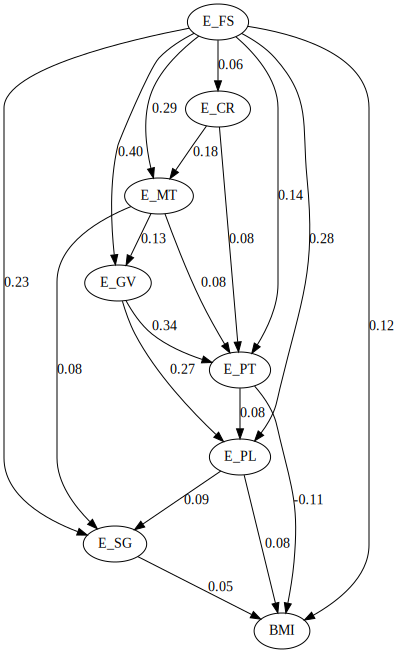

array([[0.00000000e+000, 5.03931565e-285, 3.61448456e-004,
        1.05258074e-005, 1.24462290e-004, 1.52887749e-002,
        1.40538508e-247, 2.72480204e-001],
       [5.03931565e-285, 0.00000000e+000, 1.19757106e-070,
        1.18823564e-015, 2.55757133e-073, 7.73592931e-066,
        2.08587484e-120, 1.19587346e-108],
       [3.61448456e-004, 1.19757106e-070, 0.00000000e+000,
        6.64641180e-078, 0.00000000e+000, 0.00000000e+000,
        8.13440596e-024, 0.00000000e+000],
       [1.05258074e-005, 1.18823564e-015, 6.64641180e-078,
        0.00000000e+000, 2.10234795e-066, 3.03936933e-077,
        1.73766109e-008, 7.23679193e-132],
       [1.24462290e-004, 2.55757133e-073, 0.00000000e+000,
        2.10234795e-066, 0.00000000e+000, 0.00000000e+000,
        1.03445808e-025, 0.00000000e+000],
       [1.52887749e-002, 7.73592931e-066, 0.00000000e+000,
        3.03936933e-077, 0.00000000e+000, 0.00000000e+000,
        7.79048585e-039, 0.00000000e+000],
       [1.40538508e-247, 2.0858748

因果順序
[5, 0, 6, 4, 1, 3, 2, 7]


隣接行列


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.07755519,  0.        ,  0.        ],
       [ 0.09562439,  0.        ,  0.        ,  0.        ,  0.32305448,
         0.11346162,  0.12750852,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.26259627,  0.        ,  0.        ],
       [ 0.        ,  0.11798937,  0.        ,  0.        ,  0.21024627,
         0.27670402,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.40746572,  0.16695496,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.20090786,  0.        ,  0.        ,  0.        ,  0.        ,
         0.29041473,  0.        ,  0.        ],
       [-0.07101804, -0.14427185,  0.        ,  0.1074008 ,  0.        ,
         0.11455652,  0.        ,  0.        ]])

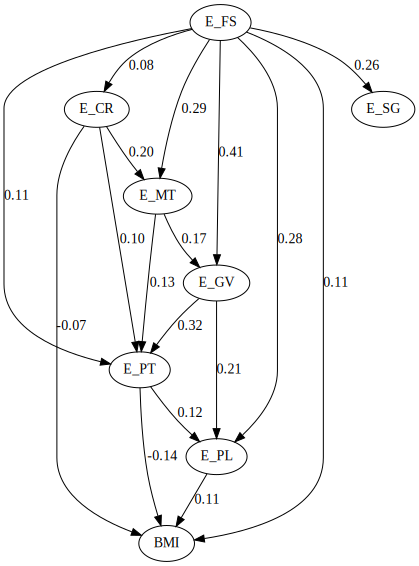

array([[0.00000000e+000, 2.18482921e-172, 5.24003693e-002,
        1.24749260e-002, 3.14407861e-004, 3.15928067e-002,
        1.02871692e-129, 2.02877317e-292],
       [2.18482921e-172, 0.00000000e+000, 2.30216555e-014,
        1.66060449e-006, 7.58838540e-032, 3.04625514e-018,
        8.20128256e-065, 7.38475905e-089],
       [5.24003693e-002, 2.30216555e-014, 0.00000000e+000,
        8.95137454e-023, 2.77867062e-214, 1.85400650e-297,
        2.04750726e-008, 5.61111883e-033],
       [1.24749260e-002, 1.66060449e-006, 8.95137454e-023,
        0.00000000e+000, 2.17225069e-028, 1.23342451e-032,
        1.31989240e-002, 1.36739248e-010],
       [3.14407861e-004, 7.58838540e-032, 2.77867062e-214,
        2.17225069e-028, 0.00000000e+000, 4.64711936e-310,
        8.56639221e-008, 1.21820956e-028],
       [3.15928067e-002, 3.04625514e-018, 1.85400650e-297,
        1.23342451e-032, 4.64711936e-310, 0.00000000e+000,
        5.81820158e-012, 5.30120851e-041],
       [1.02871692e-129, 8.2012825

因果順序
[5, 0, 6, 4, 1, 3, 2, 7]


隣接行列


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.08660511,  0.        ,  0.        ,  0.        ,  0.33279385,
         0.17305187,  0.05535906,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.11569251,  0.07627026,
         0.20975162,  0.10162146,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.33142919,
         0.29302045,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.40112814,  0.12178498,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.13559161,  0.        ,  0.        ,  0.        ,  0.        ,
         0.2927859 ,  0.        ,  0.        ],
       [-0.09642433,  0.        ,  0.        ,  0.        ,  0.        ,
         0.14290127,  0.        ,  0.        ]])

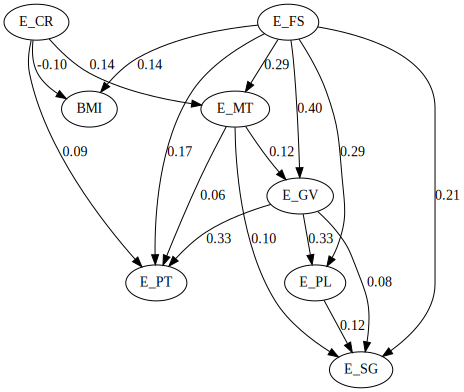

array([[0.00000000e+000, 1.77547634e-142, 1.40607559e-004,
        3.07804491e-003, 5.36744635e-004, 4.59679701e-004,
        5.84433639e-065, 0.00000000e+000],
       [1.77547634e-142, 0.00000000e+000, 1.25126107e-041,
        1.87923622e-008, 3.84051614e-035, 2.71884019e-040,
        2.33240385e-043, 8.72622022e-095],
       [1.40607559e-004, 1.25126107e-041, 0.00000000e+000,
        3.22922095e-053, 0.00000000e+000, 0.00000000e+000,
        1.79751420e-024, 4.00995054e-072],
       [3.07804491e-003, 1.87923622e-008, 3.22922095e-053,
        0.00000000e+000, 6.79007441e-035, 4.34096885e-041,
        7.79986015e-004, 2.06292139e-020],
       [5.36744635e-004, 3.84051614e-035, 0.00000000e+000,
        6.79007441e-035, 0.00000000e+000, 0.00000000e+000,
        5.97231943e-018, 9.58116165e-068],
       [4.59679701e-004, 2.71884019e-040, 0.00000000e+000,
        4.34096885e-041, 0.00000000e+000, 0.00000000e+000,
        5.87571293e-021, 9.06883187e-101],
       [5.84433639e-065, 2.3324038

In [ ]:
# # マルチリンガム
model = model_MultiDirectLiNGAM(fnutrRatio_data_list)

In [ ]:
# ブートストラップ法：引数（データフレームリスト, サンプル回数）
pretty_causal_effects = model_MultiBootstrap(fnutrRatio_data_list, 1000)
display(pretty_causal_effects)

fnutrRatio_bootstrap_0=============================================
因果方法top10
E_SG <--- E_FS (b>0) (100.0%)
E_PL <--- E_FS (b>0) (99.9%)
E_PL <--- E_GV (b>0) (99.9%)
E_PT <--- E_FS (b>0) (99.3%)
E_MT <--- E_FS (b>0) (99.2%)
E_PT <--- E_GV (b>0) (99.1%)
E_GV <--- E_FS (b>0) (98.6%)
E_PT <--- E_MT (b>0) (96.9%)
E_PL <--- E_PT (b>0) (92.2%)
E_MT <--- E_CR (b>0) (91.8%)

カウント確率


,E_CR,E_PT,E_SG,E_PL,E_GV,E_FS,E_MT,BMI
E_CR,0.000,0.063,0.025,0.019,0.038,0.366,0.082,0.023
E_PT,0.914,0.000,0.045,0.060,0.991,0.993,0.969,0.537
E_SG,0.062,0.186,0.000,0.632,0.477,1.000,0.874,0.251
E_PL,0.381,0.922,0.317,0.000,0.999,0.999,0.147,0.555
E_GV,0.063,0.009,0.014,0.001,0.000,0.986,0.866,0.098
E_FS,0.323,0.007,0.000,0.001,0.014,0.000,0.008,0.267
E_MT,0.918,0.010,0.031,0.002,0.134,0.992,0.000,0.057
BMI,0.438,0.421,0.305,0.404,0.162,0.733,0.075,0.000



DAGのカウント結果
DAG[0]: 0.8%
	E_CR <--- E_FS (b>0)
	E_PT <--- E_CR (b>0)
	E_PT <--- E_GV (b>0)
	E_PT <--- E_FS (b>0)
	E_PT <--- E_MT (b>0)
	E_SG <--- E_PL (b>0)
	E_SG <--- E_FS (b>0)
	E_SG <--- E_MT (b>0)
	E_PL <--- E_PT (b>0)
	E_PL <--- E_GV (b>0)
	E_PL <--- E_FS (b>0)
	E_GV <--- E_FS (b>0)
	E_GV <--- E_MT (b>0)
	E_MT <--- E_CR (b>0)
	E_MT <--- E_FS (b>0)
	BMI <--- E_PT (b<0)
	BMI <--- E_SG (b>0)
	BMI <--- E_PL (b>0)
	BMI <--- E_FS (b>0)
DAG[1]: 0.8%
	E_CR <--- E_FS (b>0)
	E_PT <--- E_CR (b>0)
	E_PT <--- E_GV (b>0)
	E_PT <--- E_FS (b>0)
	E_PT <--- E_MT (b>0)
	E_SG <--- E_PL (b>0)
	E_SG <--- E_FS (b>0)
	E_SG <--- E_MT (b>0)
	E_PL <--- E_PT (b>0)
	E_PL <--- E_GV (b>0)
	E_PL <--- E_FS (b>0)
	E_GV <--- E_FS (b>0)
	E_GV <--- E_MT (b>0)
	E_MT <--- E_CR (b>0)
	E_MT <--- E_FS (b>0)
	BMI <--- E_PT (b<0)
	BMI <--- E_PL (b>0)
	BMI <--- E_FS (b>0)
DAG[2]: 0.7%
	E_PT <--- E_CR (b>0)
	E_PT <--- E_GV (b>0)
	E_PT <--- E_FS (b>0)
	E_PT <--- E_MT (b>0)
	E_PT <--- BMI (b<0)
	E_SG <--- E_PT (b>0)
	E_SG <--- 

,from,to,effect,probability
0,E_FS,E_SG,0.295870,1.000
1,E_FS,E_PL,0.425158,0.999
2,E_GV,E_PL,0.297263,0.999
3,E_FS,E_PT,0.323591,0.993
4,E_FS,E_MT,0.298874,0.992
5,E_GV,E_PT,0.339099,0.991
6,E_FS,E_GV,0.439901,0.986
7,E_MT,E_PT,0.124092,0.986
8,E_CR,E_PT,0.114060,0.930
9,E_PT,E_PL,0.092028,0.920


fnutrRatio_bootstrap_1=============================================
因果方法top10
E_SG <--- E_FS (b>0) (100.0%)
E_PL <--- E_GV (b>0) (99.9%)
E_PL <--- E_FS (b>0) (99.9%)
E_MT <--- E_FS (b>0) (99.1%)
E_PT <--- E_GV (b>0) (99.1%)
E_GV <--- E_FS (b>0) (98.6%)
E_PT <--- E_MT (b>0) (97.7%)
E_PT <--- E_FS (b>0) (93.4%)
E_MT <--- E_CR (b>0) (91.8%)
E_PL <--- E_PT (b>0) (86.9%)

カウント確率


,E_CR,E_PT,E_SG,E_PL,E_GV,E_FS,E_MT,BMI
E_CR,0.000,0.066,0.009,0.012,0.076,0.235,0.082,0.036
E_PT,0.843,0.000,0.041,0.057,0.991,0.934,0.977,0.518
E_SG,0.006,0.084,0.000,0.068,0.044,1.000,0.052,0.035
E_PL,0.251,0.869,0.043,0.000,0.999,0.999,0.105,0.510
E_GV,0.369,0.009,0.001,0.001,0.000,0.986,0.865,0.176
E_FS,0.278,0.007,0.000,0.001,0.014,0.000,0.008,0.242
E_MT,0.918,0.011,0.005,0.006,0.131,0.991,0.000,0.011
BMI,0.648,0.408,0.154,0.365,0.163,0.670,0.014,0.000



DAGのカウント結果
DAG[0]: 1.0%
	E_PT <--- E_CR (b>0)
	E_PT <--- E_GV (b>0)
	E_PT <--- E_FS (b>0)
	E_PT <--- E_MT (b>0)
	E_PT <--- BMI (b<0)
	E_SG <--- E_FS (b>0)
	E_PL <--- E_PT (b>0)
	E_PL <--- E_GV (b>0)
	E_PL <--- E_FS (b>0)
	E_PL <--- BMI (b>0)
	E_GV <--- E_FS (b>0)
	E_GV <--- E_MT (b>0)
	E_FS <--- E_CR (b>0)
	E_FS <--- BMI (b>0)
	E_MT <--- E_CR (b>0)
	E_MT <--- E_FS (b>0)
	BMI <--- E_CR (b<0)
DAG[1]: 1.0%
	E_PT <--- E_CR (b>0)
	E_PT <--- E_GV (b>0)
	E_PT <--- E_FS (b>0)
	E_PT <--- E_MT (b>0)
	E_PT <--- BMI (b<0)
	E_SG <--- E_FS (b>0)
	E_PL <--- E_PT (b>0)
	E_PL <--- E_GV (b>0)
	E_PL <--- E_FS (b>0)
	E_PL <--- BMI (b>0)
	E_GV <--- E_FS (b>0)
	E_GV <--- E_MT (b>0)
	E_MT <--- E_CR (b>0)
	E_MT <--- E_FS (b>0)
	BMI <--- E_CR (b<0)
	BMI <--- E_FS (b>0)
DAG[2]: 0.9%
	E_PT <--- E_CR (b>0)
	E_PT <--- E_GV (b>0)
	E_PT <--- E_FS (b>0)
	E_PT <--- E_MT (b>0)
	E_PT <--- BMI (b<0)
	E_SG <--- E_FS (b>0)
	E_PL <--- E_PT (b>0)
	E_PL <--- E_GV (b>0)
	E_PL <--- E_FS (b>0)
	E_PL <--- BMI (b>0)
	E_GV <--- E_

,from,to,effect,probability
0,E_FS,E_SG,0.261428,1.000
1,E_FS,E_PL,0.409510,0.999
2,E_GV,E_PL,0.253405,0.999
3,E_FS,E_PT,0.308635,0.993
4,E_FS,E_MT,0.299324,0.992
5,E_GV,E_PT,0.328424,0.991
6,E_MT,E_PT,0.173090,0.987
7,E_FS,E_GV,0.457176,0.986
8,E_CR,E_PT,0.159963,0.930
9,E_CR,E_MT,0.213435,0.918


fnutrRatio_bootstrap_2=============================================
因果方法top10
E_SG <--- E_FS (b>0) (100.0%)
E_PL <--- E_FS (b>0) (99.9%)
E_PL <--- E_GV (b>0) (99.9%)
E_PT <--- E_FS (b>0) (99.3%)
E_MT <--- E_FS (b>0) (99.2%)
E_PT <--- E_GV (b>0) (99.1%)
E_GV <--- E_FS (b>0) (98.6%)
E_SG <--- E_MT (b>0) (92.7%)
E_MT <--- E_CR (b>0) (91.8%)
BMI <--- E_CR (b<0) (85.3%)

カウント確率


,E_CR,E_PT,E_SG,E_PL,E_GV,E_FS,E_MT,BMI
E_CR,0.000,0.063,0.001,0.021,0.045,0.078,0.082,0.051
E_PT,0.838,0.000,0.030,0.045,0.991,0.993,0.575,0.087
E_SG,0.015,0.153,0.000,0.636,0.789,1.000,0.927,0.172
E_PL,0.276,0.560,0.343,0.000,0.999,0.999,0.120,0.178
E_GV,0.158,0.009,0.025,0.001,0.000,0.986,0.851,0.012
E_FS,0.066,0.007,0.000,0.001,0.014,0.000,0.008,0.267
E_MT,0.918,0.007,0.034,0.007,0.133,0.992,0.000,0.101
BMI,0.853,0.058,0.159,0.182,0.019,0.728,0.114,0.000



DAGのカウント結果
DAG[0]: 1.0%
	E_PT <--- E_CR (b>0)
	E_PT <--- E_GV (b>0)
	E_PT <--- E_FS (b>0)
	E_PT <--- E_MT (b>0)
	E_SG <--- E_PL (b>0)
	E_SG <--- E_GV (b>0)
	E_SG <--- E_FS (b>0)
	E_SG <--- E_MT (b>0)
	E_PL <--- E_GV (b>0)
	E_PL <--- E_FS (b>0)
	E_GV <--- E_FS (b>0)
	E_GV <--- E_MT (b>0)
	E_MT <--- E_CR (b>0)
	E_MT <--- E_FS (b>0)
	BMI <--- E_CR (b<0)
	BMI <--- E_FS (b>0)
DAG[1]: 0.7%
	E_PT <--- E_CR (b>0)
	E_PT <--- E_GV (b>0)
	E_PT <--- E_FS (b>0)
	E_PT <--- E_MT (b>0)
	E_SG <--- E_PL (b>0)
	E_SG <--- E_GV (b>0)
	E_SG <--- E_FS (b>0)
	E_SG <--- E_MT (b>0)
	E_PL <--- E_PT (b>0)
	E_PL <--- E_GV (b>0)
	E_PL <--- E_FS (b>0)
	E_GV <--- E_FS (b>0)
	E_GV <--- E_MT (b>0)
	E_MT <--- E_CR (b>0)
	E_MT <--- E_FS (b>0)
	BMI <--- E_CR (b<0)
	BMI <--- E_FS (b>0)
DAG[2]: 0.7%
	E_PT <--- E_CR (b>0)
	E_PT <--- E_GV (b>0)
	E_PT <--- E_FS (b>0)
	E_SG <--- E_PL (b>0)
	E_SG <--- E_GV (b>0)
	E_SG <--- E_FS (b>0)
	E_SG <--- E_MT (b>0)
	E_PL <--- E_GV (b>0)
	E_PL <--- E_FS (b>0)
	E_GV <--- E_FS (b>0)
	E_GV <

,from,to,effect,probability
0,E_FS,E_SG,0.323311,1.000
1,E_GV,E_PL,0.333754,0.999
2,E_FS,E_PL,0.436779,0.999
3,E_FS,E_PT,0.338356,0.993
4,E_FS,E_MT,0.294645,0.992
5,E_GV,E_PT,0.337495,0.991
6,E_FS,E_GV,0.437134,0.986
7,E_GV,E_SG,0.117390,0.960
8,E_MT,E_SG,0.112484,0.936
9,E_CR,E_MT,0.140041,0.918


None

## --サンプリング回数1000、全体0.8%, 男性1.0%, 女性1.0%
##魚、肉はpattern2と同様に他の変数からの影響を受けにくいように見える。男性と女性でBMIの位置が大きく異なるのは、性別によってエネルギーの取り方から受ける影響が異なるからか、エネルギーの取り方自体が異なるからと言えそう。女性は穀類、魚、男性は2つに加えて芋類、豆類からBMIに影響を受けている。